## University of California - Irvine
### Bank Marketing Data Set

### From UCI:
**Input variables:**

**bank client data:**
- 1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')

**related with the last contact of the current campaign:**
- 8 - contact: contact communication type (categorical: 'cellular','telephone') 
- 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**
- 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- 14 - previous: number of contacts performed before this campaign and for this client (numeric)
- 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**social and economic context attributes**
- 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
- 17 - cons.price.idx: consumer price index - monthly indicator (numeric) 
- 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
- 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
- 20 - nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**
- 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt

%matplotlib inline
from IPython.display import display
pd.options.display.max_rows = 100
pd.options.display.max_columns = None

import seaborn as sns
sns.set()

# Pre Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score, StratifiedKFold, validation_curve, GridSearchCV

# Over Sampling
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN

# Classic Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Neural Network
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import sklearn.metrics as metrics


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df_original=pd.read_csv("c:/data/bank-additional-full.csv",sep=';')
df_original=df_original.drop(['duration'],axis=1) # Per instructions from UC Irvine 
df_original.loc[df_original.pdays == 999, 'pdays'] = np.nan # 999 = No data from UCI.
df = df_original.copy()

print(df.shape)
display(df.head())

(41188, 20)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Extend the DataFrame describe() method to show nunique, null counts and column type. 

In [3]:
def extended_describe(df):
    de = df.describe()

    nu = pd.DataFrame(df.nunique())
    nu.columns = ['nunique']
    nu = nu.transpose()

    nan = pd.DataFrame(df.isnull().sum(axis=0))
    nan.columns = ['nan']
    nan = nan.transpose()

    de = de.append([nu, nan], sort=False).transpose()
    de['categorical'] = de['count'].isnull()
    de.index.name = 'column'
    return de

In [4]:
de = extended_describe(df)
de

,count,mean,std,min,25%,50%,75%,max,nunique,nan,categorical
column,,,,,,,,,,,
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000,78.0,0.0,False
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000,42.0,0.0,False
pdays,1515.0,6.014521,3.824906,0.000,3.000,6.000,7.000,27.000,26.0,39673.0,False
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000,8.0,0.0,False
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400,10.0,0.0,False
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767,26.0,0.0,False
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900,26.0,0.0,False
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045,316.0,0.0,False
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100,11.0,0.0,False


In [5]:
numeric_columns = list(de.loc[de.categorical == False].reset_index()['column'])
categorical_columns = list(de.loc[de.categorical == True].reset_index()['column'])
# print(numeric_columns, categorical_columns)

## Outliers 
Looking at the 25th percentile and the min, as well as the 75th percentile and the max, the data does not have any extremes that we need to deal with. 
  
## Null Values 
Only pdays (days since last phone contact) has null values.  In the original dataset, this was set to 999, but was changed to nan after load.  The far majority of the values are null.   
  
### pdays 
The output variable is the column **y** (did the prospect sign up for a term deposit).  So, let's see if pdays has a significant correlation of to the output variable. 

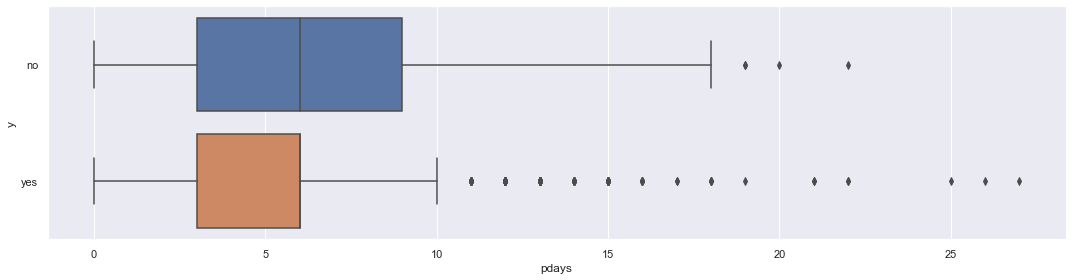

In [6]:
f = plt.figure(figsize=(15, 4))
sns.boxplot(x=df['pdays'], y=df['y'])
f.tight_layout()
plt.show()

The positive outcomes have a shorter **pdays** value.  So, let's keep the feature, but convert it to a categorical column and drop the numeric column. 

In [7]:
pdays_columns = ['no_contact', 'contact_0_5', 'contact_5_10', 'contact_10_15', 'contact_20']

df[pdays_columns[0]] = 0
df[pdays_columns[0]][df.pdays.isnull()] = 1

df[pdays_columns[1]] = 0
df[pdays_columns[1]][df.pdays <= 5] = 1

df[pdays_columns[2]] = 0
df[pdays_columns[2]][(df.pdays > 5) & (df.pdays <= 10)] = 1

df[pdays_columns[3]] = 0
df[pdays_columns[3]][(df.pdays > 15) & (df.pdays <= 20)] = 1

df[pdays_columns[4]] = 0
df[pdays_columns[4]][df.pdays > 20] = 1
                                     
df.drop('pdays', axis=1, inplace=True);
numeric_columns.remove('pdays')
categorical_columns = categorical_columns + pdays_columns

### Now let's look at the value counts for the categorical columns (sans dummies we just built). 

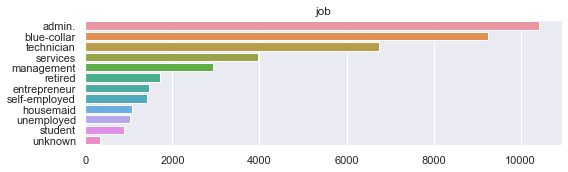

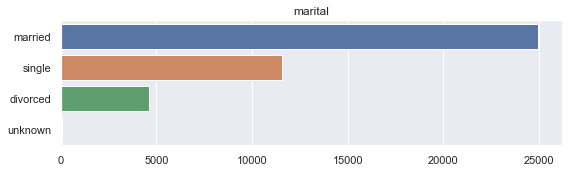

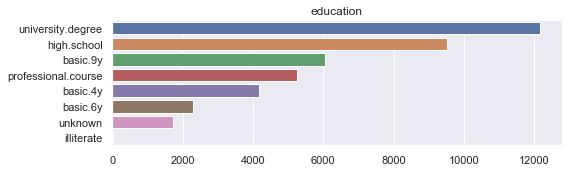

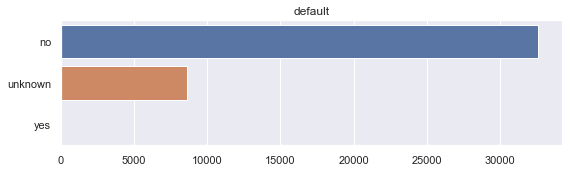

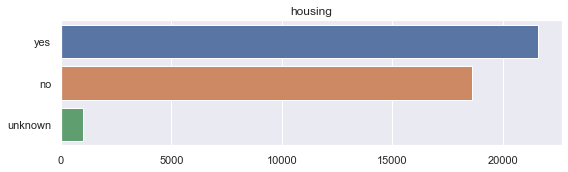

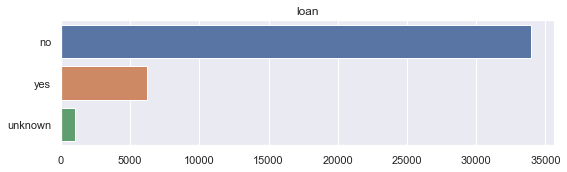

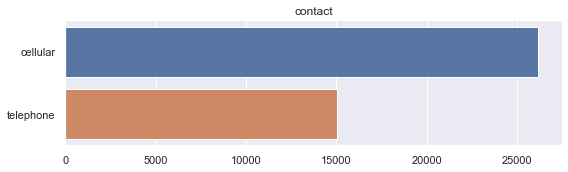

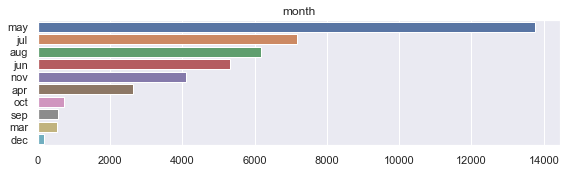

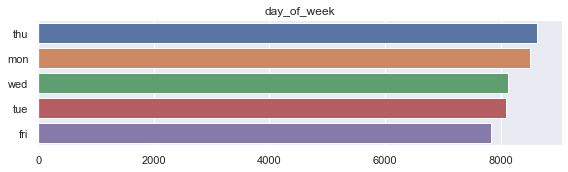

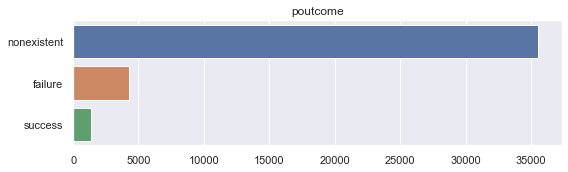

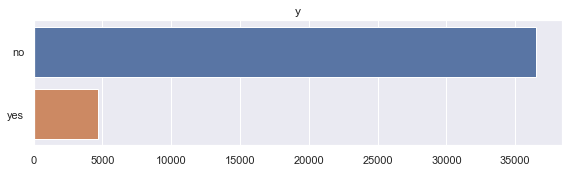

In [8]:
categorical_columns_sans_pdays = [c for c in categorical_columns if c not in pdays_columns]
for col in categorical_columns_sans_pdays:
    plt.figure(figsize=(8,2.5))
    sns.barplot(df[col].value_counts().values, df[col].value_counts().index)
    plt.title(col)
    plt.tight_layout()   

### For numeric features, let's look at histograms. 

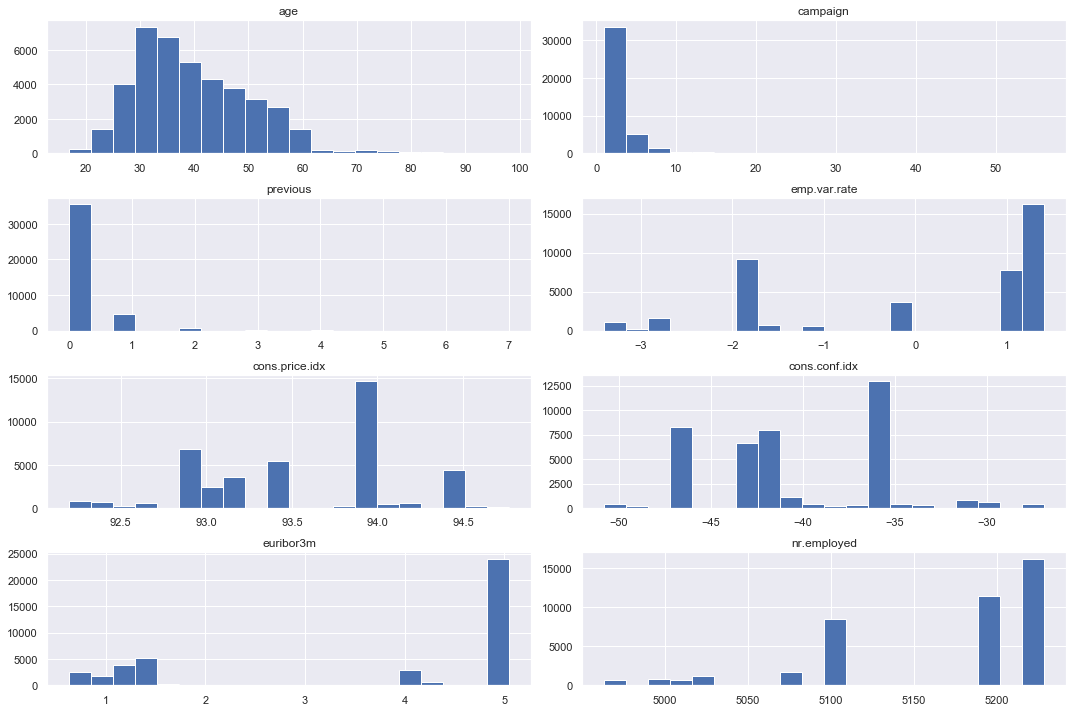

In [9]:
i = 0
j = 0
row_count = len(numeric_columns) // 2
f = plt.figure(figsize=(15, 10))
gs = f.add_gridspec(row_count, 2)

for col in numeric_columns:
    ax = f.add_subplot(gs[i, j])
    ax.hist(df[col], bins=20)
    ax.set_title(col)
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1

f.tight_layout()
plt.show()

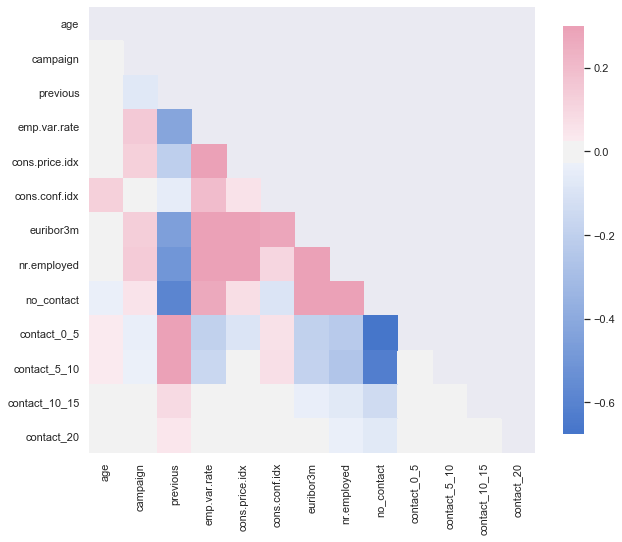

In [10]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(255, 0, as_cmap=True)

f = plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, cbar_kws={"shrink": .75})

## Imbalanced Data

#### Only 11% of the data produced a positive outcome

'YES' = Success marketing to sign up an account.

In [11]:
print("Percent of rows labeled as \'YES\' = {0:.0%}".format(sum(df.y=='yes')/len(df)))
print("Percent of rows labeled as \'NO\' = {0:.0%}".format(sum(df.y=='no')/len(df)))

Percent of rows labeled as 'YES' = 11%
Percent of rows labeled as 'NO' = 89%


# Approach

### Classifiers

We will be looking at 4 different classifiers
- Logistic Regression
- Random Forest
- Gradient Boosting
- Simple Neural Network


### Preprocessing Features:

Random Forest and Gradient Boosting are based on decision trees.  Logistic and NN are based on a linear approach.  
Because of this, we will preprocess the dataset in two different ways.  The decision tree models do not need any prep other than oversampling, whereas the linear models will need hot-one encoding (categorical features) and some type of standardization (numeric features).

#### Oversampling
Since EDA did not show any significant outliers and the small number of null values were already taken care of, the most import general preprocessing step is to compensate for the imbalanced data.  

We will use SMOTE for oversampling.  Oversampling will be done only on the training data, but not test.  Since we will be using cross validation, the validation datasets will also be oversampling.  There are some disucssions online around only oversampling the training portion of each CV fold, but for this project we will oversample all the training data before we do CV.

Since SMOTE uses K means clustering, which needs to have only numeric features.  SKLearn allows us to do this conversation automaticaly via SMOTENC which can accept both numeric and catagorical features.

### Steps
- Split into train and test
- Use SMOTE on the training data
- Clone test dataset to allow for 2 difference branches for preprocessing
    -   Linear: Apply standardization and dummies to the data copies used for the linear models
    -   Decision Tree: Though we do not need to do any prep work on these, SKLearn requires all features to be numeric.  To accomplish this, we will use LabelEncoding which does: ["a", "b", "c", "d"] -> [1,2,3,4]


In [12]:
df_copy = df.copy()
df_copy.y = df_copy.y.map({'yes':1, 'no':0}) # Clean up output feature while we are here

train, test = train_test_split(df_copy, train_size=.8, random_state=42)
    
# Split into featurs and output
X_train = train.drop(['y'], axis=1)
y_train = train['y']
X_test = test.drop(['y'], axis=1)
y_test = test['y']

#We can't use our categorical_columns variable since we just removed the 'y' column.
#So we need to find the columns in X_t
X_train_all_columns = X_train.columns
X_train_numeric_columns = X_train._get_numeric_data().columns
X_train_categorical_columns = list(set(X_train_all_columns) - set(X_train_numeric_columns))
X_train_categorical_column_indexes = X_train.columns.get_indexer(X_train_categorical_columns)
print("Numeric Columns:\n", X_train_numeric_columns)
print("\nCategorical Columns:\n", X_train_categorical_columns)
  
# Oversample
sm = SMOTENC(X_train_categorical_column_indexes, random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print("\nPercent of rows labeled as \'NO\' = {:.0%}".format(y_train.sum()/len(y_train)))
    
# Clone the features (both train and test) to allow for different preprocessing later
decision_tree_X_train = X_train
decision_tree_X_test = X_test
linear_X_train= X_train.copy()
linear_X_test= X_test.copy()

Numeric Columns:
 Index(['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'no_contact',
       'contact_0_5', 'contact_5_10', 'contact_10_15', 'contact_20'],
      dtype='object')

Categorical Columns:
 ['day_of_week', 'default', 'loan', 'education', 'month', 'marital', 'contact', 'housing', 'poutcome', 'job']

Percent of rows labeled as 'NO' = 50%


In [13]:
def getScaledDataFrame(df):
    mms = MinMaxScaler()
    mms.fit(df)

    result = pd.DataFrame(mms.transform(df))
    result.columns = df.columns
    result.index = df.index
    return result


In [14]:
def getLabelEncodedDataFrame(df):
    encoder = LabelEncoder()
    for c in X_train_categorical_columns:
        encoder.fit(df[c])
        df[c] = encoder.transform(df[c])
    return df

#### Preprocess Full Training Dataset

In [15]:
decision_tree_X_test = getLabelEncodedDataFrame(decision_tree_X_test)

decision_tree_X_train = getLabelEncodedDataFrame(decision_tree_X_train)
decision_tree_X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,no_contact,contact_0_5,contact_5_10,contact_10_15,contact_20
0,40,1,1,2,1,2,0,1,3,1,2,0,1,1.4,93.918,-42.7,4.960,5228.1,1,0,0,0,0
1,31,0,1,6,0,0,0,0,6,1,4,0,1,-1.8,92.893,-46.2,1.244,5099.1,1,0,0,0,0
2,59,5,1,0,0,0,0,0,6,1,6,1,0,-1.8,92.893,-46.2,1.354,5099.1,1,0,0,0,0
3,43,3,0,2,0,2,0,0,3,3,5,0,1,1.4,93.918,-42.7,4.961,5228.1,1,0,0,0,0
4,39,0,2,3,1,0,0,1,6,2,2,0,1,1.1,93.994,-36.4,4.860,5191.0,1,0,0,0,0


In [16]:
linear_X_test = pd.get_dummies(linear_X_test, drop_first=True)
linear_X_test = getScaledDataFrame(linear_X_test)

linear_X_train = pd.get_dummies(linear_X_train, drop_first=True)
linear_X_train = getScaledDataFrame(linear_X_train)

# Since one-hot encoding creates columns based on values
# it is possible that there are some values in test that are not in train and vice versa
# So we need to add missing colums with a value of 0 to that both training datasets have the same features
missing_cols = set(linear_X_train.columns) - set(linear_X_test.columns)
for c in missing_cols:
    linear_X_test[c] = 0
    
missing_cols = set(linear_X_test.columns) - set(linear_X_train.columns)
for c in missing_cols:
    linear_X_train[c] = 0    


linear_X_train.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,no_contact,contact_0_5,contact_5_10,contact_10_15,contact_20,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,0.283951,0.018182,0.000000,1.000000,0.669135,0.338912,0.980730,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.172840,0.054545,0.000000,0.333333,0.269680,0.192469,0.138291,0.512287,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.518519,0.090909,0.142857,0.333333,0.269680,0.192469,0.163228,0.512287,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.320988,0.072727,0.000000,1.000000,0.669135,0.338912,0.980957,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.271605,0.018182,0.000000,0.937500,0.698753,0.602510,0.958059,0.859735,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [17]:
def printGridSearchCVResults(clf):
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
 

In [18]:
def runGridSearchCV(clf, grid_values, X, y):
    gs = GridSearchCV(clf, grid_values)
    gs.fit(X, y)
    printGridSearchCVResults(gs)

### Lets find the Best Hyperparameters for our Models

#### Logistic Regression Parameters

In [19]:
logit = LogisticRegression(random_state = 42, solver='saga')
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
#runGridSearchCV(logit, grid_values, linear_X_train, y_train)


'''
Grid scores on development set:

0.720 (+/-0.003) for {'C': 0.001, 'penalty': 'l1'}
0.753 (+/-0.016) for {'C': 0.001, 'penalty': 'l2'}
0.759 (+/-0.029) for {'C': 0.01, 'penalty': 'l1'}
0.767 (+/-0.033) for {'C': 0.01, 'penalty': 'l2'}
0.772 (+/-0.051) for {'C': 0.1, 'penalty': 'l1'}
0.770 (+/-0.048) for {'C': 0.1, 'penalty': 'l2'}
0.774 (+/-0.055) for {'C': 1, 'penalty': 'l1'}
0.773 (+/-0.055) for {'C': 1, 'penalty': 'l2'}
0.774 (+/-0.056) for {'C': 10, 'penalty': 'l1'}
0.774 (+/-0.056) for {'C': 10, 'penalty': 'l2'}
0.774 (+/-0.056) for {'C': 100, 'penalty': 'l1'}
0.774 (+/-0.056) for {'C': 100, 'penalty': 'l2'}
0.774 (+/-0.056) for {'C': 1000, 'penalty': 'l1'}
0.774 (+/-0.056) for {'C': 1000, 'penalty': 'l2'}
'''

print('Best parameters set found on development set:')

print("'C': 100\n'penalty': 'l2'")

Best parameters set found on development set:
'C': 100
'penalty': 'l2'


#### Random Forest Parameters

In [20]:
rf = RandomForestClassifier()
grid_values = {'bootstrap': [True, False],
               'max_depth': [10, 50, 100, None],
               'max_features': ["auto", "sqrt"],
               'min_samples_leaf': [2, 4, 8],
               'n_estimators': [200, 400, 1000]}  
#runGridSearchCV(rf, grid_values, decision_tree_X_train, y_train)


'''
Grid scores on development set:

0.796 (+/-0.042) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 200}
0.796 (+/-0.042) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 400}
0.795 (+/-0.042) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.795 (+/-0.038) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 200}
0.795 (+/-0.042) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 400}
0.795 (+/-0.040) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.794 (+/-0.035) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 200}
0.795 (+/-0.036) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 400}
0.794 (+/-0.036) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.797 (+/-0.044) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
0.795 (+/-0.042) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 400}
0.796 (+/-0.042) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.795 (+/-0.040) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
0.794 (+/-0.040) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
0.796 (+/-0.040) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.795 (+/-0.036) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 200}
0.794 (+/-0.038) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 400}
0.794 (+/-0.038) for {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.914 (+/-0.115) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 200}
0.914 (+/-0.114) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 400}
0.914 (+/-0.115) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.903 (+/-0.102) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 200}
0.902 (+/-0.103) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 400}
0.903 (+/-0.103) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.884 (+/-0.088) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 200}
0.885 (+/-0.087) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 400}
0.885 (+/-0.086) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.913 (+/-0.115) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
0.914 (+/-0.114) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 400}
0.914 (+/-0.115) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.903 (+/-0.102) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
0.903 (+/-0.103) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
0.902 (+/-0.101) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.885 (+/-0.088) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 200}
0.885 (+/-0.087) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 400}
0.885 (+/-0.087) for {'bootstrap': True, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.914 (+/-0.114) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 200}
0.914 (+/-0.115) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 400}
0.914 (+/-0.116) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.902 (+/-0.102) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 200}
0.903 (+/-0.102) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 400}
0.903 (+/-0.102) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.885 (+/-0.088) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 200}
0.884 (+/-0.087) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 400}
0.885 (+/-0.087) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.914 (+/-0.115) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
0.915 (+/-0.114) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 400}
0.914 (+/-0.115) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.902 (+/-0.102) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
0.902 (+/-0.102) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
0.903 (+/-0.101) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.884 (+/-0.087) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 200}
0.885 (+/-0.089) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 400}
0.885 (+/-0.087) for {'bootstrap': True, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.914 (+/-0.115) for {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 200}
0.914 (+/-0.114) for {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 400}
0.914 (+/-0.116) for {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.902 (+/-0.102) for {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 200}
0.903 (+/-0.102) for {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 400}
0.903 (+/-0.102) for {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.885 (+/-0.088) for {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 200}
0.885 (+/-0.088) for {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 400}
0.885 (+/-0.086) for {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.914 (+/-0.114) for {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
0.914 (+/-0.115) for {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 400}
0.914 (+/-0.116) for {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.902 (+/-0.103) for {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
0.903 (+/-0.103) for {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
0.903 (+/-0.101) for {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.884 (+/-0.086) for {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 200}
0.886 (+/-0.089) for {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 400}
0.885 (+/-0.088) for {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.796 (+/-0.044) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 200}
0.796 (+/-0.044) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 400}
0.796 (+/-0.046) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.795 (+/-0.047) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 200}
0.796 (+/-0.043) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 400}
0.795 (+/-0.043) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.794 (+/-0.039) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 200}
0.795 (+/-0.043) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 400}
0.795 (+/-0.041) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.796 (+/-0.046) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
0.795 (+/-0.045) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 400}
0.795 (+/-0.046) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.796 (+/-0.043) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
0.796 (+/-0.042) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
0.796 (+/-0.043) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.795 (+/-0.041) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 200}
0.794 (+/-0.041) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 400}
0.795 (+/-0.041) for {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.918 (+/-0.125) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 200}
0.918 (+/-0.125) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 400}
0.918 (+/-0.125) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.911 (+/-0.114) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 200}
0.911 (+/-0.113) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 400}
0.911 (+/-0.113) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.898 (+/-0.099) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 200}
0.897 (+/-0.099) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 400}
0.897 (+/-0.098) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.918 (+/-0.126) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
0.919 (+/-0.125) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 400}
0.918 (+/-0.125) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.911 (+/-0.114) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
0.911 (+/-0.114) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
0.911 (+/-0.114) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.897 (+/-0.097) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 200}
0.897 (+/-0.099) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 400}
0.897 (+/-0.099) for {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.918 (+/-0.126) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 200}
0.918 (+/-0.125) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 400}
0.918 (+/-0.126) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.910 (+/-0.114) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 200}
0.911 (+/-0.113) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 400}
0.910 (+/-0.114) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.897 (+/-0.100) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 200}
0.897 (+/-0.099) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 400}
0.897 (+/-0.098) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.918 (+/-0.126) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
0.918 (+/-0.127) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 400}
0.918 (+/-0.126) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.911 (+/-0.113) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
0.911 (+/-0.114) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
0.911 (+/-0.114) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.897 (+/-0.098) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 200}
0.897 (+/-0.098) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 400}
0.897 (+/-0.099) for {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.918 (+/-0.126) for {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 200}
0.918 (+/-0.125) for {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 400}
0.918 (+/-0.126) for {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.911 (+/-0.112) for {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 200}
0.910 (+/-0.113) for {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 400}
0.911 (+/-0.113) for {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.897 (+/-0.097) for {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 200}
0.898 (+/-0.099) for {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 400}
0.898 (+/-0.100) for {'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 1000}
0.918 (+/-0.125) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
0.919 (+/-0.125) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 400}
0.918 (+/-0.126) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 1000}
0.910 (+/-0.113) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
0.910 (+/-0.114) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 400}
0.911 (+/-0.113) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 1000}
0.897 (+/-0.098) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 200}
0.898 (+/-0.098) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 400}
0.898 (+/-0.099) for {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'n_estimators': 1000}
'''


print('Best parameters set found on development set:')

print("'bootstrap': False\n'max_depth': None\n'max_features': 'sqrt'\n'min_samples_leaf': 2\n'n_estimators': 400")


Best parameters set found on development set:
'bootstrap': False
'max_depth': None
'max_features': 'sqrt'
'min_samples_leaf': 2
'n_estimators': 400


#### Gradient Boosting Parameters

In [21]:
gb = GradientBoostingClassifier()
grid_values = {"loss":["deviance"],
               "learning_rate": [1e-1, 1e-2, 1e-3, 1e-4],
               "max_depth":[2,4,8],
               "max_features":["log2","sqrt"],
               "criterion": ["friedman_mse",  "mae"],
               "n_estimators":[10]}  
# runGridSearchCV(gb, grid_values, decision_tree_X_train, y_train)


'''
Grid scores on development set:

0.743 (+/-0.012) for {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 10}
0.738 (+/-0.018) for {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}
0.758 (+/-0.012) for {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 10}
0.756 (+/-0.015) for {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10}
0.794 (+/-0.039) for {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 10}
0.794 (+/-0.042) for {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 10}
0.729 (+/-0.005) for {'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 10}
0.732 (+/-0.015) for {'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}
0.752 (+/-0.015) for {'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 10}
0.754 (+/-0.009) for {'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10}
0.780 (+/-0.030) for {'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 10}
0.781 (+/-0.033) for {'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 10}
0.742 (+/-0.020) for {'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 10}
0.732 (+/-0.014) for {'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}
0.756 (+/-0.015) for {'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 10}
0.751 (+/-0.009) for {'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10}
0.779 (+/-0.030) for {'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 10}
0.780 (+/-0.032) for {'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 10}
0.729 (+/-0.020) for {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 10}
0.727 (+/-0.012) for {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}
0.750 (+/-0.016) for {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 10}
0.751 (+/-0.016) for {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10}
0.782 (+/-0.034) for {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 10}
0.779 (+/-0.037) for {'criterion': 'friedman_mse', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 10}
0.727 (+/-0.012) for {'criterion': 'mae', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 10}
0.727 (+/-0.013) for {'criterion': 'mae', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}
0.749 (+/-0.018) for {'criterion': 'mae', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 10}
0.750 (+/-0.013) for {'criterion': 'mae', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10}
0.778 (+/-0.036) for {'criterion': 'mae', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 10}
0.779 (+/-0.038) for {'criterion': 'mae', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 10}
0.724 (+/-0.009) for {'criterion': 'mae', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 10}
0.726 (+/-0.017) for {'criterion': 'mae', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}
0.744 (+/-0.010) for {'criterion': 'mae', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 10}
0.747 (+/-0.024) for {'criterion': 'mae', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10}
0.772 (+/-0.028) for {'criterion': 'mae', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 10}
0.766 (+/-0.030) for {'criterion': 'mae', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 10}
0.722 (+/-0.011) for {'criterion': 'mae', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 10}
0.728 (+/-0.014) for {'criterion': 'mae', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}
0.742 (+/-0.012) for {'criterion': 'mae', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 10}
0.739 (+/-0.014) for {'criterion': 'mae', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10}
0.769 (+/-0.028) for {'criterion': 'mae', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 10}
0.766 (+/-0.026) for {'criterion': 'mae', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 10}
0.723 (+/-0.011) for {'criterion': 'mae', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 10}
0.722 (+/-0.007) for {'criterion': 'mae', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 2, 'max_features': 'sqrt', 'n_estimators': 10}
0.745 (+/-0.010) for {'criterion': 'mae', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 10}
0.741 (+/-0.013) for {'criterion': 'mae', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 10}
0.770 (+/-0.029) for {'criterion': 'mae', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 10}
0.764 (+/-0.025) for {'criterion': 'mae', 'learning_rate': 0.0001, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 10}
'''


print('Best parameters set found on development set:')

print("'criterion': 'friedman_mse'\n'learning_rate': 0.1\n'loss': 'deviance'\n'max_depth': 8\n'max_features': 'log2'\n'n_estimators': 10")


Best parameters set found on development set:
'criterion': 'friedman_mse'
'learning_rate': 0.1
'loss': 'deviance'
'max_depth': 8
'max_features': 'log2'
'n_estimators': 10


#### Simple Neural Network (Multi-layer Preceptron) Parameters

In [22]:
mlp = MLPClassifier(random_state=42)
grid_values = {'activation':['logistic','relu'],'solver': ['lbfgs','adam','sgd'],
               'alpha':10.0 ** -np.arange(1,4),
               'hidden_layer_sizes':[(20),(4),(10),(14,2),(4,1),(10,5),(11,3)]}  
#runGridSearchCV(mlp, grid_values, linear_X_train, y_train)


'''
Grid scores on development set:

0.896 (+/-0.003) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 20, 'solver': 'lbfgs'}
0.900 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 20, 'solver': 'adam'}
0.898 (+/-0.002) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 20, 'solver': 'sgd'}
0.900 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 4, 'solver': 'lbfgs'}
0.901 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 4, 'solver': 'adam'}
0.898 (+/-0.001) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 4, 'solver': 'sgd'}
0.898 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 10, 'solver': 'lbfgs'}
0.900 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 10, 'solver': 'adam'}
0.899 (+/-0.002) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': 10, 'solver': 'sgd'}
0.896 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (14, 2), 'solver': 'lbfgs'}
0.901 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (14, 2), 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (14, 2), 'solver': 'sgd'}
0.898 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (4, 1), 'solver': 'lbfgs'}
0.900 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (4, 1), 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (4, 1), 'solver': 'sgd'}
0.897 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (10, 5), 'solver': 'lbfgs'}
0.900 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (10, 5), 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'}
0.896 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (11, 3), 'solver': 'lbfgs'}
0.900 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (11, 3), 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (11, 3), 'solver': 'sgd'}
0.896 (+/-0.003) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 20, 'solver': 'lbfgs'}
0.901 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 20, 'solver': 'adam'}
0.899 (+/-0.002) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 20, 'solver': 'sgd'}
0.899 (+/-0.003) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 4, 'solver': 'lbfgs'}
0.901 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 4, 'solver': 'adam'}
0.899 (+/-0.002) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 4, 'solver': 'sgd'}
0.896 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 10, 'solver': 'lbfgs'}
0.900 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 10, 'solver': 'adam'}
0.900 (+/-0.003) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 10, 'solver': 'sgd'}
0.896 (+/-0.007) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (14, 2), 'solver': 'lbfgs'}
0.900 (+/-0.007) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (14, 2), 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (14, 2), 'solver': 'sgd'}
0.898 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (4, 1), 'solver': 'lbfgs'}
0.897 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (4, 1), 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (4, 1), 'solver': 'sgd'}
0.898 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (10, 5), 'solver': 'lbfgs'}
0.900 (+/-0.007) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (10, 5), 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'}
0.895 (+/-0.006) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (11, 3), 'solver': 'lbfgs'}
0.897 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (11, 3), 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (11, 3), 'solver': 'sgd'}
0.895 (+/-0.002) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 20, 'solver': 'lbfgs'}
0.901 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 20, 'solver': 'adam'}
0.899 (+/-0.002) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 20, 'solver': 'sgd'}
0.899 (+/-0.006) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 4, 'solver': 'lbfgs'}
0.901 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 4, 'solver': 'adam'}
0.899 (+/-0.002) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 4, 'solver': 'sgd'}
0.897 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 10, 'solver': 'lbfgs'}
0.902 (+/-0.003) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 10, 'solver': 'adam'}
0.900 (+/-0.003) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 10, 'solver': 'sgd'}
0.898 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (14, 2), 'solver': 'lbfgs'}
0.897 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (14, 2), 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (14, 2), 'solver': 'sgd'}
0.899 (+/-0.002) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (4, 1), 'solver': 'lbfgs'}
0.896 (+/-0.006) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (4, 1), 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (4, 1), 'solver': 'sgd'}
0.898 (+/-0.006) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (10, 5), 'solver': 'lbfgs'}
0.900 (+/-0.004) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (10, 5), 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'}
0.895 (+/-0.006) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (11, 3), 'solver': 'lbfgs'}
0.897 (+/-0.005) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (11, 3), 'solver': 'adam'}
0.888 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (11, 3), 'solver': 'sgd'}
0.895 (+/-0.005) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 20, 'solver': 'lbfgs'}
0.901 (+/-0.003) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 20, 'solver': 'adam'}
0.900 (+/-0.003) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 20, 'solver': 'sgd'}
0.900 (+/-0.003) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 4, 'solver': 'lbfgs'}
0.901 (+/-0.003) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 4, 'solver': 'adam'}
0.899 (+/-0.004) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 4, 'solver': 'sgd'}
0.898 (+/-0.005) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 10, 'solver': 'lbfgs'}
0.901 (+/-0.004) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 10, 'solver': 'adam'}
0.899 (+/-0.002) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 10, 'solver': 'sgd'}
0.898 (+/-0.006) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (14, 2), 'solver': 'lbfgs'}
0.899 (+/-0.005) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (14, 2), 'solver': 'adam'}
0.899 (+/-0.005) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (14, 2), 'solver': 'sgd'}
0.900 (+/-0.006) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (4, 1), 'solver': 'lbfgs'}
0.901 (+/-0.004) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (4, 1), 'solver': 'adam'}
0.898 (+/-0.003) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (4, 1), 'solver': 'sgd'}
0.897 (+/-0.006) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (10, 5), 'solver': 'lbfgs'}
0.900 (+/-0.004) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (10, 5), 'solver': 'adam'}
0.900 (+/-0.004) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'}
0.899 (+/-0.006) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (11, 3), 'solver': 'lbfgs'}
0.898 (+/-0.005) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (11, 3), 'solver': 'adam'}
0.899 (+/-0.005) for {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (11, 3), 'solver': 'sgd'}
0.896 (+/-0.005) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 20, 'solver': 'lbfgs'}
0.898 (+/-0.005) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 20, 'solver': 'adam'}
0.900 (+/-0.004) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 20, 'solver': 'sgd'}
0.900 (+/-0.005) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 4, 'solver': 'lbfgs'}
0.900 (+/-0.004) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 4, 'solver': 'adam'}
0.899 (+/-0.004) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 4, 'solver': 'sgd'}
0.897 (+/-0.003) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 10, 'solver': 'lbfgs'}
0.899 (+/-0.003) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 10, 'solver': 'adam'}
0.899 (+/-0.003) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 10, 'solver': 'sgd'}
0.898 (+/-0.006) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (14, 2), 'solver': 'lbfgs'}
0.896 (+/-0.003) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (14, 2), 'solver': 'adam'}
0.899 (+/-0.004) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (14, 2), 'solver': 'sgd'}
0.900 (+/-0.006) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (4, 1), 'solver': 'lbfgs'}
0.897 (+/-0.004) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (4, 1), 'solver': 'adam'}
0.895 (+/-0.008) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (4, 1), 'solver': 'sgd'}
0.897 (+/-0.004) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10, 5), 'solver': 'lbfgs'}
0.899 (+/-0.005) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10, 5), 'solver': 'adam'}
0.900 (+/-0.003) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'}
0.898 (+/-0.007) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (11, 3), 'solver': 'lbfgs'}
0.898 (+/-0.006) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (11, 3), 'solver': 'adam'}
0.899 (+/-0.006) for {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (11, 3), 'solver': 'sgd'}
0.895 (+/-0.007) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 20, 'solver': 'lbfgs'}
0.897 (+/-0.004) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 20, 'solver': 'adam'}
0.900 (+/-0.004) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 20, 'solver': 'sgd'}
0.899 (+/-0.003) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 4, 'solver': 'lbfgs'}
0.900 (+/-0.004) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 4, 'solver': 'adam'}
0.899 (+/-0.004) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 4, 'solver': 'sgd'}
0.897 (+/-0.004) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 10, 'solver': 'lbfgs'}
0.899 (+/-0.003) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 10, 'solver': 'adam'}
0.899 (+/-0.003) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 10, 'solver': 'sgd'}
0.898 (+/-0.007) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (14, 2), 'solver': 'lbfgs'}
0.897 (+/-0.002) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (14, 2), 'solver': 'adam'}
0.899 (+/-0.004) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (14, 2), 'solver': 'sgd'}
0.900 (+/-0.005) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (4, 1), 'solver': 'lbfgs'}
0.897 (+/-0.005) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (4, 1), 'solver': 'adam'}
0.895 (+/-0.008) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (4, 1), 'solver': 'sgd'}
0.897 (+/-0.006) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10, 5), 'solver': 'lbfgs'}
0.899 (+/-0.005) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10, 5), 'solver': 'adam'}
0.900 (+/-0.004) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'}
0.898 (+/-0.008) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (11, 3), 'solver': 'lbfgs'}
0.897 (+/-0.004) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (11, 3), 'solver': 'adam'}
0.899 (+/-0.006) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (11, 3), 'solver': 'sgd'}
'''

print('Best parameters set found on development set:')

print("'activation': 'logistic'\n'alpha': 0.001\n'hidden_layer_sizes': 10\n'solver': 'adam'")


Best parameters set found on development set:
'activation': 'logistic'
'alpha': 0.001
'hidden_layer_sizes': 10
'solver': 'adam'


In [23]:
def display_binary_classification_results(y_test, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
    
    str_cm = [
                ['TP: {:,}'.format(TP), 'FP: {:,}'.format(FP)],
                ['FN: {:,}'.format(FN), 'TN: {:,}'.format(TN)]
             ] 
    display(
                pd.DataFrame(str_cm, columns=['Actual Positive', 'Actual Negative'], 
                index=['Predicted Positive', 'Predicted Negative'])
    )
    
    accuracy = (TP + TN) / (TP + TN + FP + FN) # how many predictions were right
    recall = TP / (TP + FN) # % of TP for all Actual positives
    precision = TP / (TP + FP) # % of TP for all Predicted positives
    F1 = (2 * TP) / (2*TP + FP + FN) # harmonic mean ("avg of fractions") between precision and recall
    
    print('Accuracy: {:%}'.format(accuracy))
    print('Sensitivity (Recall): {:%}'.format(recall))
    print('Precision: {:%}'.format(precision))
    print('F1: {:%}'.format(F1))

In [24]:
def plot_ROC_cross_validation(clf, x, y, folds):
    tprs = []
    aucs = []
    cv = StratifiedKFold(n_splits=folds)
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(12, 8))
    for i, (train, test) in enumerate(cv.split(x, y)):
        clf.fit(x.iloc[train], y.iloc[train])
        viz = metrics.plot_roc_curve(clf, x.iloc[test], y.iloc[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic example")
    ax.legend(loc="lower right")
    plt.show()

# RUN MODELS

## Logistic Regression

,Actual Positive,Actual Negative
Predicted Positive,TP: 543,"FP: 2,797"
Predicted Negative,FN: 392,"TN: 4,506"


Accuracy: 61.289148%
Sensitivity (Recall): 58.074866%
Precision: 16.257485%
F1: 25.403509%


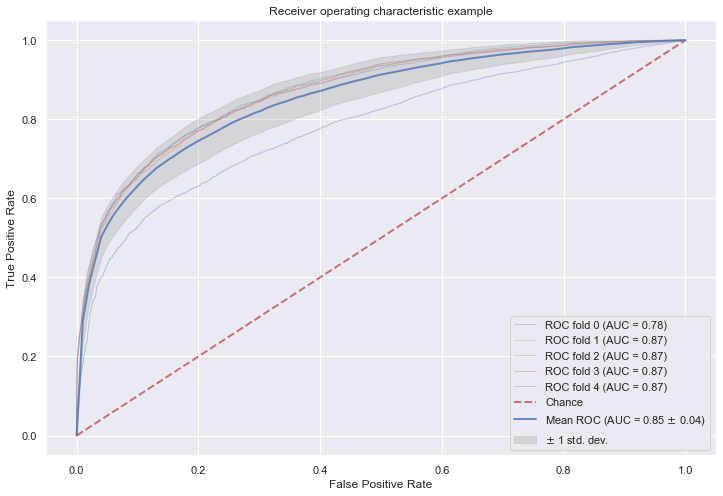

In [25]:
'''
Best parameters set found on development set:
'C': 100
'penalty': 'l2'
'''
logit = LogisticRegression(C=100, penalty='l2', random_state = 42)
logit.fit(linear_X_train, y_train)

y_pred = logit.predict(linear_X_test)

display_binary_classification_results(y_test, y_pred)

plot_ROC_cross_validation(logit, linear_X_train, y_train, folds=5)

## Random Forest

,Actual Positive,Actual Negative
Predicted Positive,TP: 392,FP: 499
Predicted Negative,FN: 543,"TN: 6,804"


Accuracy: 87.351299%
Sensitivity (Recall): 41.925134%
Precision: 43.995511%
F1: 42.935378%


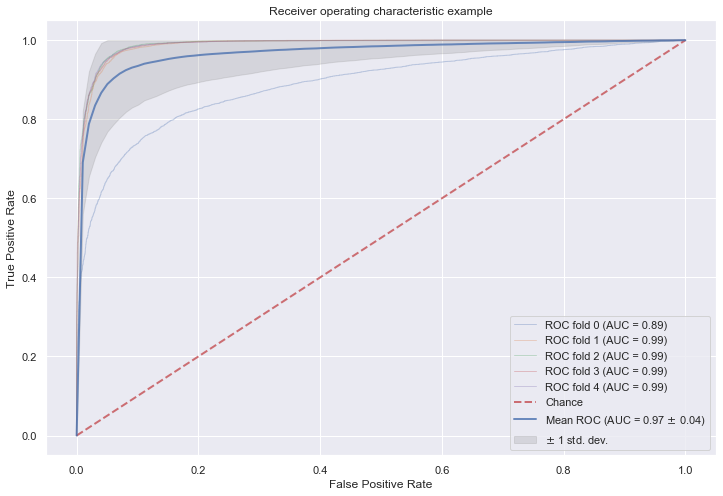

In [26]:
'''
'bootstrap': False
'max_depth': None
'max_features': 'sqrt'
'min_samples_leaf': 2
'n_estimators': 400
'''

rf = RandomForestClassifier(bootstrap=False,
                             max_depth=None,
                             max_features='sqrt',
                             min_samples_leaf=2,
                             n_estimators=400, 
                             random_state= 42)
rf.fit(decision_tree_X_train, y_train)

y_pred = rf.predict(decision_tree_X_test)

display_binary_classification_results(y_test, y_pred)

plot_ROC_cross_validation(rf, decision_tree_X_train, y_train, folds=5)

## Gradient Boosting

,Actual Positive,Actual Negative
Predicted Positive,TP: 515,FP: 887
Predicted Negative,FN: 420,"TN: 6,416"


Accuracy: 84.134499%
Sensitivity (Recall): 55.080214%
Precision: 36.733238%
F1: 44.073599%


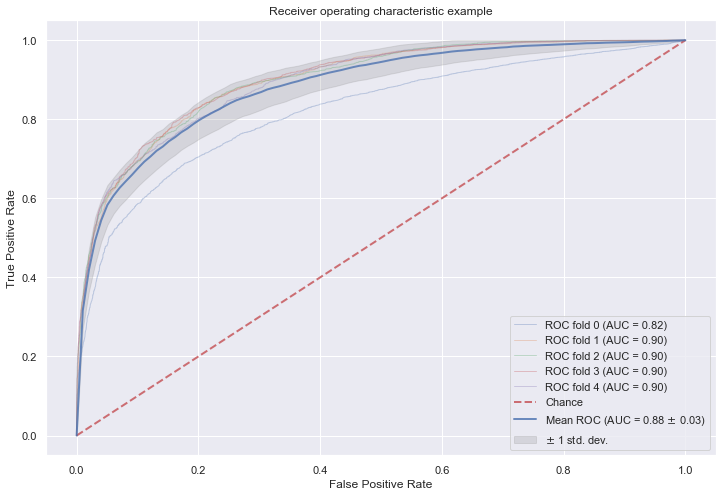

In [27]:
'''
'criterion': 'friedman_mse'
'learning_rate': 0.1
'loss': 'deviance'
'max_depth': 8
'max_features': 'log2'
'n_estimators': 10
'''

gb = GradientBoostingClassifier(criterion='friedman_mse',
                                learning_rate=0.1,
                                loss='deviance',
                                max_depth=8,
                                max_features='log2', 
                                n_estimators = 10,
                                random_state= 42)
gb.fit(decision_tree_X_train, y_train)

y_pred = gb.predict(decision_tree_X_test)

display_binary_classification_results(y_test, y_pred)

plot_ROC_cross_validation(gb, decision_tree_X_train, y_train, folds=5)

## Simple Neural Network (Multi-layer Preceptron)

In [ ]:
'''
'activation': 'logistic'
'alpha': 0.001
'hidden_layer_sizes': 10
'solver': 'adam'
'''
mlp = MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=10, solver='adam', random_state = 42)
mlp.fit(linear_X_train, y_train)

y_pred = mlp.predict(linear_X_test)

display_binary_classification_results(y_test, y_pred)

plot_ROC_cross_validation(mlp, linear_X_train, y_train, folds=5)

# Conslusions

Random Forest performed the best.  The accuracy rate and the area under the curve in the ROC curve was significantly better then other models.  

None of the models had great recall or precision.  This probably due to the fact that the test data has a significant imbalance between TP and TN.  During training, we oversampled the positive rows to achieve a better fit.  But we don't want to do this for the test data.  

The numbers for the **Random Forest** were:

    TP: 385
    FP: 504
    FN: 550
    TN: 6,799

For formulas are:

    recall = TP / (TP + FN) = 53%
    precision = TP / (TP + FP) = 37%

If we simply negate the target (change which label is "positive"), we would get:

    TN: 385
    FN: 504
    FP: 550
    TP: 6,799
    
    recall = TP / (TP + FN) = 6799 / (6799 + 504) = 93%
    precision = TP / (TP + FP) = 37% = 6799 / (6799 + 550) = 93%
    
These inverted number better reflect the 87% accuracy we see with Random Forest.

If we were taking this model to production, we would probably do more analysis to make sure RF and it's parameters are actually the best. Specifically making sure the parameters for the grid search are the best.  We only used 2 parameters for Logistic Regression.  Also, if you look at the preceptron model, the grid scores were pretty tight, whereas the Random Forest values has a large range.  This may indicate that one or more of the numeric parameter ranges did not include the optimal value.  i.e. the best value in a range was either the highest or lowest value.

We also need to consider the logistic of taking each model to production.  RF tends to be an easy to productionize so the initial good results for Random Forest along with might just warrant further parameter tuning.

Looking at the variance in the CV ROC curves, we see the common pattern.  4 of the 5 folds produced curves that were very tight while one of the folds produced a consistently lower curve.  This might be that that fold happens to hold data that is not a good match for the trained model.  But this assumes that StratifiedKFold is deterministic.  It could be each fold is generated differently with each ROC curve.

Random Forest looks like the variance between the 5 folds is the greatest.  We would need to do more analysis on this before going to production to make sure we didn't overfit on our training data.  The above curve's variance is qualitative, and RF's variance might just be a visual artifact since the 1Z range looks bigger since the curve is tucked into the corner a lot more than the other models.

Gradient boost looked to have the lowest variance across the 5 folds.  This could indicate that this model is could be better over the long run.  Since it is also a decision tree approach, the production logistics could be similar to RF.

We also do not have any goals set for the prediction.  Is sensitivity more important than precision or vice versa?  Is there were a set goals, it would help a lot in our ability to pick and/or tune the model.

